# Assignment #3 - Reinforcement Learning

### <font color="red"> DUE: Mar 19 (Monday) 11:00 pm </font>  

<font color="blue"> Yangqi Su </font>

# I. Overview

In this assignment, the goal is to code two Reinforcement Agents, one for navigating a customly given maze and the other for playing a special version of blackjack provided by the openAI gym. I made both the agents using both Q-learning and SARSA learning.

# II. Problems 

## A. Maze Problem (Practice)

In this first problem, the environment is a maze, which is provided by a text file to an object of class GridWorld. The agent will try to learn an path to G: goal location without running into H or outside of the grid.

In [2]:
import collections
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Sample Grid Environment File

Simple text file with three characters, 'O', 'H', and 'G'.
- 'O': open space
- 'H': Wall or obstacles
- 'G': Goal location 

In [362]:
%%bash 
cat grid.txt

OOOHOOOOO
OOOHOOOHO
OOOOOOOHO
OOOOHHHOO
OOHOOOOOH
OOHOOOGOO
OOOOOOOOO


### GridWorld Class

The GridWorld class explanation of some of the methods:

**__init__**: initializes the class object and reads a grid from a file, dtereimnes the location of the Goal, determines the shape of grid and initializes the actions: left, up, down, right.

__get_cur_state__: returns the current state

__get_size__: returns map shape

__check_state__: check if state is valid, if its outside of grid returns 'N', if invalid returns 'F', else returns state value:

__init__: initiates a starting point on the map

__next__: move a step on the map according to an action and return a reward:
- if next state is an H or N: do not update the current state to next state, return a reward of -5
- if next state is O, return -1
- if next state is G, return 30
- if next state is invalid, return -5


In [3]:
# maze example

class GridWorld:
    """ Grid World environment
            there are four actions (left, right, up, and down) to move an agent
            In a grid, if it reaches a goal, it get 30 points of reward.
            If it falls in a hole or moves out of the grid world, it gets -5.
            Each step costs -1 point. 

        to test GridWorld, run the following sample codes:

            env = GridWorld('grid.txt')

            env.print_map()
            print [2,3], env.check_state([2,3])
            print [0,0], env.check_state([0,0])
            print [3,4], env.check_state([3,4])
            print [10,3], env.check_state([10,3])

            env.init([0,0])
            print env.next(1)  # right
            print env.next(3)  # down
            print env.next(0)  # left
            print env.next(2)  # up
            print env.next(2)  # up

        Parameters
        ==========
        _map        ndarray
                    string array read from a file input
        _size       1d array
                    the size of _map in ndarray
        goal_pos    tuple
                    the index for the goal location
        _actions    list
                    list of actions for 4 actions
        _s          1d array
                    current state
    """
    def __init__(self, fn):
        # read a map from a file
        self._map = self.read_map(fn)
        self._size = np.asarray(self._map.shape)
        self.goal_pos = np.where(self._map == 'G')

        # definition of actions (left, right, up, and down repectively)
        self._actions = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self._s = None

    def get_cur_state(self):
        return self._s

    def get_size(self):
        return self._size

    def read_map(self, fn):
        grid = []
        with open(fn) as f:
            for line in f:
               grid.append(list(line.strip()))
        return np.asarray(grid)

    def print_map(self):
        print( self._map )

    def check_state(self, s):
        if isinstance(s, collections.Iterable) and len(s) == 2:
            if s[0] < 0 or s[1] < 0 or\
               s[0] >= self._size[0] or s[1] >= self._size[1]:
               return 'N'
            return self._map[tuple(s)].upper()
        else:
            return 'F'  # wrong input

    def init(self, state=None):
        if state is None:
            s = [0, 0]
        else:
            s = state

        if self.check_state(s) == 'O':
            self._s = np.asarray(state)
        else:
            raise ValueError("Invalid state for init")

    def next(self, a):
        s1 = self._s + self._actions[a]
        # state transition
        curr = self.check_state(s1)
        
        if curr == 'H' or curr == 'N':
            return -5
        elif curr == 'F':
            warnings.warn("invalid state " + str(s1))
            return -5
        elif curr == 'G':
            self._s = s1
            return 30
        else:
            self._s = s1
            return -1
        
    def is_goal(self):
        return self.check_state(self._s) == 'G'
            
    def get_actions(self):
        return self._actions

In [5]:
env = GridWorld("grid.txt")
env.print_map()

[['O' 'O' 'O' 'H' 'O' 'O' 'O' 'O' 'O']
 ['O' 'O' 'O' 'H' 'O' 'O' 'O' 'H' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'H' 'O']
 ['O' 'O' 'O' 'O' 'H' 'H' 'H' 'O' 'O']
 ['O' 'O' 'H' 'O' 'O' 'O' 'O' 'O' 'H']
 ['O' 'O' 'H' 'O' 'O' 'O' 'G' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']]


In [4]:
# top-left to (0,0)
def coord_convert(s, sz):
    return [s[1], sz[0]-s[0]-1]

## B. Blackjack-V0

![](https://upload.wikimedia.org/wikipedia/commons/a/a2/Blackjack_game_1.JPG)

Now, we play Blackjack! 
https://gym.openai.com/envs/Blackjack-v0/


The blackjack problem is presented as such:

**types of cards:** [1,2,3,4,5,6,7,8,9,10]; There are 4 10s, and 1 can be 11 or 1 depending on the total of the cards in the hand. The cards are choosen with replacement

The player is dealt 2 cards, which he or she can only see the sum of; The dealer is dealt also dealt 2 cards, of which the player can only see one card. The goal for the player is to get a final total higher than the dealer before going above 21 by either asking for more cards (hitting) or staying with what he or she has (stay). After a player stays, the dealer shows both cards and keeps adding cards until he or she has a total over or equal to 17.

The dealer deals the player a hand each time **reset()** is called, the player recieves a sum of the total cards in his or her hand, one card of the dealer and whether there is an usable ace in return. Next the player chooses an action 1 or 0 to the function **step()**, to determine if he or she will hit or stay, from which the player will recieve an reward of:
- -1 if player hits and busts
- 0 if player hits and doesn't bust
- -1 if player stays and dealer ends up winning
- 1 if player stays and wins

# III. Methods

- Decide your TD learning approach: SARSA or Q-learning? 

My learning approach for the maze problem is SARSA, and my learning approach for the blackjack problem is Q-learning.

- Describe your approach and the reason why you select it.

SARSA learning updates the current state action value with the reward and next state's choose action value. This means it is a on-policy learning process, because it updates its current policy with values of its current policy. Upon convergence, it will reach a near optimal policy.

$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)) 
$$

Q-learning updates the current state action value with the maximum possible state-action value of the next state. It does does, because it assumes that it is following the optimal policy, thus it is not learning based on the current policy, hence it is an off-policy learning approach.

$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)) 
$$

In comparison of the two different approaches, Q-learning attempts to learn directly from the optimal approach and SARSA attempts to converge to a near optimal approach. In the classic cliff problem, it can be seen that Q-learning will converge to an optimal even if such an optimal approach can be dangerous when explored. SARSA on the other hand will learn from its own policy that the most optimal approach can lead to large negative rewards when explored, thus it will find a more conservative policy.

- Finish epsilon_greedy function and other TODOs. Explain it.

The epsilon greedy function is where we decide the trade off between exploration and exploitation. A high epsilon value, means we want to explore more, and a lower epsilon value means we wish to exploit the current policy. For the Blackjack problem, the epsilon function is implemented with a custom decay function that decays the epsilon as the number of iterations increase, to decrease exploration after finding a better policy.
- Explain your codes.

Explanations are given below along the codes

## RLAgent for Maze

The RLAgent for the Maze initializes a Q table with the shape of the map given times the number of actions

Epsilon greedy function returns an action based wether to explore or exploit.

In the training parameters one can choose between SARSA or Q-learning. Also there is a random_start function that randomly chooses a starting point for each iteration. When the goal is reached, the value for the Q-table on the goal is set to zero because it is not updated, and there is no need to update this value.

The train function returns the record of rewards recieved for each iteration, the number of steps taken during each iteration and the last path the agent took to get to the goal

The test function returns the almost optimal path for the agent to reach the goal for the given starting point. This is almost optimal since the agent is doing this using epsilon greedy, thus it can still explore other path with a low probability (0.05 in this case).

In [254]:
class RLAgent: 
    """
        Reinforcement Learning Agent Model for training/testing
        with Tabular function approximation
        
    """
    
    def __init__(self, env):
        self.env = env
        self.size = env.get_size()
        self.n_a = len(env.get_actions())
        # self.Q table including the surrounding border
        self.Q = np.zeros((self.size[0], self.size[1], self.n_a))
    
    def epsilon_greed(self, epsilon, s):
        if np.random.rand() < epsilon:
            return np.random.randint(self.n_a)
        else:
            return np.argmax(self.Q[s[0], s[1], :])
    
    def train(self, start, **params):
        
        # parameters
        gamma = params.pop('gamma', 0.99)
        alpha = params.pop('alpha', 0.1)
        epsilon= params.pop('epsilon', 0.1)
        maxiter= params.pop('maxiter', 1000) 
        maxstep= params.pop('maxstep', 1000)
        method= params.pop('method', "SARSA" )
        random_start=params.pop('random_start', False)
        assert method in ["Q-learning", "SARSA"], "method has to be either 'SARSA' or 'Q-learning'"
        # init self.Q matrix
        self.Q[...] = 0
        self.Q[self.env._map == 'H'] = -np.inf
        
        # online train
        # rewards and step trace
        rtrace = []
        steps = []
        for j in range(maxiter):
            if random_start:
                while True:
                    start=[np.random.randint(self.size[0]), np.random.randint(self.size[1])]
                    try:
                        self.env.init(start)
                    except:
                        continue
                    else:
                        break
            else:
                self.env.init(start)
            s = self.env.get_cur_state()
            # selection an action
            a = self.epsilon_greed(epsilon, s)
            rewards = []
            trace = np.array(coord_convert(s, self.size))
            # run simulation for max number of steps 
            for step in range(maxstep):
                # move
                r = env.next(a)
                s1 = env.get_cur_state()
                if method == "Q-learning":
                    a1 = np.argmax(self.Q[s1[0],s1[1],:])
                elif method == "SARSA":
                    a1 = self.epsilon_greed(epsilon, s1)
                
                rewards.append(r)
                trace = np.vstack((trace, coord_convert(s1, self.size)))

                # TODO: FINISH SARSA/Q-learning Rule here
                # update self.Q table 
                self.Q[s[0],s[1],a] = self.Q[s[0],s[1],a]+alpha*(r+gamma*self.Q[s1[0], s1[1],a1]-self.Q[s[0],s[1],a])
                
                if env.is_goal(): # reached the goal
                    # TODO: Why is this zero? Describe this in your code explanation.
                    self.Q[s1[0], s1[1], a1] = 0
                    break

                s = s1
                if method == "SARSA":
                    a = a1
                elif method == "Q-learning":
                    a = self.epsilon_greed(epsilon, s)

            rtrace.append(np.sum(rewards))
            steps.append(step+1)
        return rtrace, steps, trace # last trace of trajectory

    def test(self, start, maxstep=1000):
        # TODO: Add your test routine that exmines learned policy
        #      Using the learned policy, generate the trajectory of 
        self.env.init(start)
        s = self.env.get_cur_state()
        trace = np.array(coord_convert(s, self.size))
        for steps in range(maxstep):
                a = self.epsilon_greed(0.05, s)
                r = env.next(a)
                s1 = env.get_cur_state()
                trace = np.vstack((trace, coord_convert(s1, self.size)))
                if env.is_goal(): # reached the goal
                    break
                s = s1
        return trace

## RLAgent for Gym (Blackjack-V0)
The RLAgent for the Maze initializes a Q table with the shape [18,10,2], this is because there are 18 possible types of sums for the player's hand (4 to 21), 10 types of hand for the dealers card facing up (1 to 10) and 2 actions the player can take (hit or stay).

The reward function takes in a state and reward and returns a new reward based on the input. if it is not the custom reward function, then the input reward is returned. Otherwise:
- it will return a reward of -5 if the sum of the player's hand is less than 11 and the player decided to stay (a foolish move)
- it will return a reward of -sum(player's hand)/5 if the player decided to hit, this is to penalize the player for hitting even with a large sum in hand.
- it will return 100, a large reward if the player wins this hand.
- it will return -1 if the player loses this hand with a hand larger than 11.

Epsilon greedy function returns an action based wether to explore or exploit. This function is exactly like the one in the maze agent except there is a custom decay function for the value of epsilon.

In the training parameters one can choose between SARSA or Q-learning, custom reward or not and whether to have decay.

The train and the test function returns the record of rewards in rtrace, the total number of reward at the end of each iteration in crtrace, the last 10 hands' moving average in thma, and the current win ratio.


In [333]:
class BlackJackAgent:
    """
    
    blackjack agent for openai gym's blackjack.py
    
    """
    def __init__(self, env):
        self.env = env
        self.Q = np.zeros((18, 10, 2))
        #number of actions
        self.n_a=2
        
    def reward_function(self, s, r, custom=False):
        if not custom:
            return r
        else:
            re = 0
            if s[0] < 11 and r < 0:
                re = -5
            elif r == 0:
                re = -s[0]/5
            elif r > 0:
                re =100
            else:
                re = -1
        return re
            
    def epsilon_greed(self, epsilon, s, decay=False,decay_step=None, decay_rate=None):
        if decay:
            assert decay_rate != None, 'please set decay rate'
            self.decay_rate=self.decay_rate*((decay_step+9)/float(decay_step+10))
            self.epsilon=self.epsilon*(decay_rate)
            epsilon=self.epsilon
        if np.random.rand() < epsilon:
            return np.random.randint(self.n_a)
        else:
            return np.argmax(self.Q[s[0]-4, s[1]-1, :])
        
    def train(self, **params):
        # parameters
        gamma = params.pop('gamma', 0.99)
        alpha = params.pop('alpha', 0.1)
        epsilon= params.pop('epsilon', 0.1)
        maxiter= params.pop('maxiter', 1000) 
        method= params.pop('method', "SARSA" )
        decay_rate=params.pop('decay_rate', 0.9)
        decay=params.pop('decay', False)
        custom_reward=params.pop('custom_reward', False)
        assert method in ["Q-learning", "SARSA"], "method has to be either 'SARSA' or 'Q-learning'"
        if decay:
            self.decay_rate=decay_rate
            self.epsilon=epsilon
                                             
        rtrace=[]
        crtrace=[]
        thma=[]
        wratio=[]
        for j in range(maxiter):
            s=self.env.reset()
            done=False
            # selection an action
            a = self.epsilon_greed(epsilon, s, decay=decay, decay_step=j, decay_rate=decay_rate)
            rewards = []

            # run simulation for max number of steps 
            while not done:
                # move
                result = self.env.step(a)
                s1=result[0]
                if (s1[0] > 21):
                    s1 = s
                r=result[1]
                done=result[2]
                if not custom_reward:
                    re=self.reward_function(s=s, r=r)
                else:
                    re = self.reward_function(s=s, r=r, custom=True)
                    
                if method == "Q-learning":
                    a1 = np.argmax(self.Q[s1[0]-4,s1[1]-1,:])
                elif method == "SARSA":
                    a1 = self.epsilon_greed(epsilon, s1, decay=decay, decay_step=j, decay_rate=decay_rate)
                #update
                self.Q[s[0]-4,s[1]-1,a] = self.Q[s[0]-4,s[1]-1,a]+alpha*(re+gamma*self.Q[s1[0]-4, s1[1]-1,a1]-self.Q[s[0]-4,s[1]-1,a])
                #print(self.Q[19,9,0])
                rewards.append(r)
                s = s1
                if method == "SARSA":
                    a = a1
                elif method == "Q-learning":
                    a = self.epsilon_greed(epsilon, s, decay=decay, decay_step=j, decay_rate=decay_rate)
            rtrace.append(np.sum(rewards))
            crtrace.append(np.sum(rtrace))
            wratio.append((len(np.where(np.array(rtrace) == 1)[0]))/float(len(rtrace)))
            if j >= 10:
                thma.append(np.sum(rtrace[-10:])/float(10))
            
        return rtrace, crtrace, thma, wratio# last trace of trajectory
    
    def test(self, niter=1000, epsilon=0.05):
        rtrace=[]
        crtrace=[]
        thma=[]
        wratio=[]
        for j in range(niter):
            reward=[]
            s=self.env.reset()
            done=False
            a = self.epsilon_greed(epsilon, s, decay=False, decay_step=None, decay_rate=None)
            while not done:
                result=self.env.step(a)
                s1=result[0]
                if (s1[0] > 21):
                    s1 = s
                r=result[1]
                reward.append(r)
                done=result[2]
                s = s1
                a = self.epsilon_greed(epsilon, s, decay=False, decay_step=None, decay_rate=None)
            rtrace.append(np.sum(reward))
            crtrace.append(np.sum(rtrace))
            wratio.append((len(np.where(np.array(rtrace) == 1)[0]))/float(len(rtrace)))
            if j >= 10:
                thma.append(np.sum(rtrace[-10:])/float(10))
        return rtrace, crtrace, thma, wratio

# IV - Results

- Describe the choice of your parameters for $\gamma$, $\alpha$, and $\epsilon$. 
  - Run experiments to find good parameters
  - Show the experimental outputs to show the process of your selection
- Visualize the results and explain outputs (even from mine.)
  - Run the codes and tell me what you observe
  - Add more visualizations to enrich your explanation.

### Utility functions for Plotting

- finish the TODOs here for plotting

In [331]:
### Plotting tools 

def plot_trace(agent, start, trace, title="test trajectory"):
    plt.plot(trace[:, 0], trace[:, 1], "ko-")
    plt.text(env.goal_pos[1], agent.size[0]-env.goal_pos[0]-1, 'G')
    plt.text(start[1], agent.size[0]-start[0]-1, 'S')
    plt.xlim([0, agent.size[1]])
    plt.ylim([0, agent.size[0]])
    plt.title('start: '+str(start))

    

def plot_train(agent, rtrace, steps, trace, start):

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(221)
    # TODO: plot rewards 
    plt.plot(rtrace)
    plt.ylabel("sum of rewards")

    ax1 = fig.add_subplot(222)
    # TODO: plot steps
    plt.plot(steps)
    plt.ylabel("# steps")

    # contour plot for agent.Q
    ax2 = fig.add_subplot(223)
    xs = range(agent.size[1])
    ys = range(agent.size[0])
    maxQ = np.max(agent.Q, axis=2)
    h_b = (maxQ==-np.inf)
    maxQ[h_b] = 0
    maxQ[h_b] = np.min(maxQ) - 100
    cs = plt.contourf(xs, ys[::-1], maxQ)
    plt.colorbar(cs)
    plt.text(env.goal_pos[1], agent.size[0]-env.goal_pos[0]-1, 'G')
    plt.text(start[1], agent.size[0]-start[0]-1, 'S')
    plt.ylabel("max agent.Q")

    # plot traces
    ax3 = fig.add_subplot(224)
    plot_trace(agent, start, trace, "trace of the last episode")

    plt.plot()

def plotBlackJackResults(results):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(221)
    plt.plot(results[1])
    plt.title('cumulative reward')
    ax1 = fig.add_subplot(222)
    plt.plot(results[2])
    plt.title('ten-hand MA')
    plt.xlabel("hands played")
    ax2 = fig.add_subplot(223)
    plt.plot(results[3])
    plt.title('win ratio')
    plt.xlabel("hands played")


### Training and Testing with GridWorld
To facilitate the training and reduce number of lines of output, training, plotting will be put into a one line function. Testing will be another function, in which the test's starting point will have to be a list of lists

In [178]:
def MazeTrain(env, start, gamma, alpha, epsilon, maxiter, maxstep, method, random_start):
    agent = RLAgent(env)
    start = start
    rtrace, steps, trace = agent.train(start, 
                                   gamma=gamma, 
                                   alpha=alpha, 
                                   epsilon=epsilon, 
                                   maxiter=maxiter, 
                                   maxstep=maxstep,
                                    method=method,
                                    random_start=random_start)
    plot_train(agent, rtrace, steps, trace, start)
    return agent

def MazeTest(agent, test_start):
    for test in test_start:
        test_start=test
        test_trace = agent.test(test_start)
        plt.figure()
        plot_trace(agent, test_start, test_trace)

***SARSA Training***

parameters to experiment:

    gamma: 0.1, 0.5, 0.99

    alpha: 0.01, 0.1

    epsilon: 0.5, 0.1
    
I will search through the parameters by finding the best gamma first, then with that gamma finding the best alpha and so on. The initial values for all parameters are the first values listed above

##### gamma: 0.1; alpha: 0.01; epsilon: 0.5

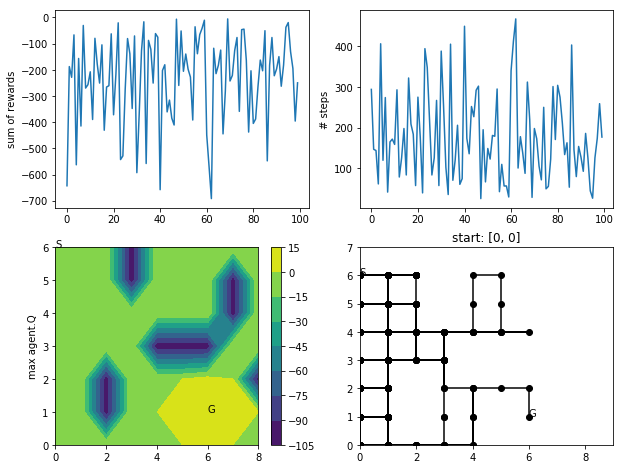

In [182]:
agent=MazeTrain(env, start=[0,0],gamma=0.1, alpha=0.01, epsilon=0.5, maxiter=100, maxstep=1000, method="SARSA", random_start=False)

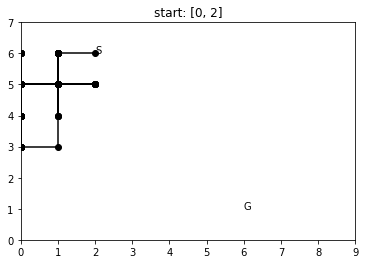

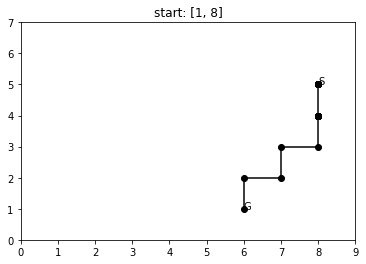

In [183]:
MazeTest(agent, test_start=[[0,2],[1,8]])

##### gamma: 0.5; alpha: 0.01; epsilon: 0.5

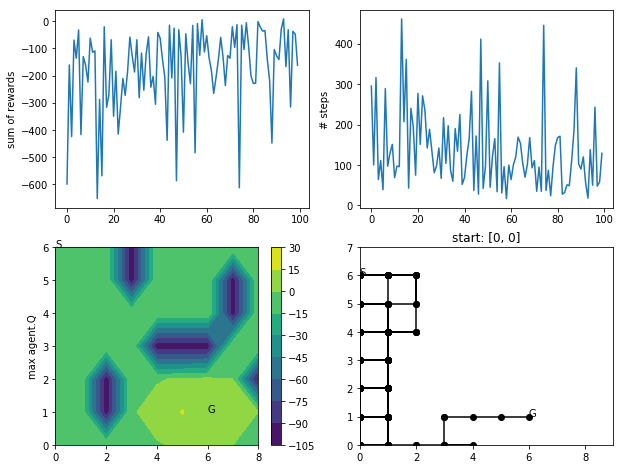

In [184]:
agent=MazeTrain(env, start=[0,0],gamma=0.5, alpha=0.01, epsilon=0.5, maxiter=100, maxstep=1000, method="SARSA", random_start=False)

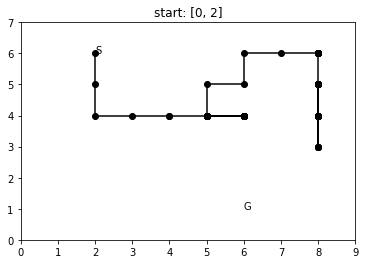

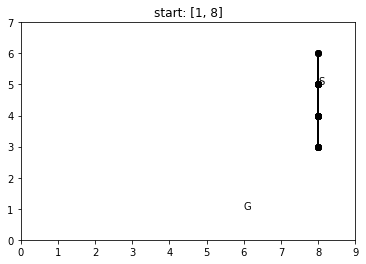

In [185]:
MazeTest(agent, test_start=[[0,2],[1,8]])

##### gamma: 0.99; alpha: 0.01; epsilon: 0.5

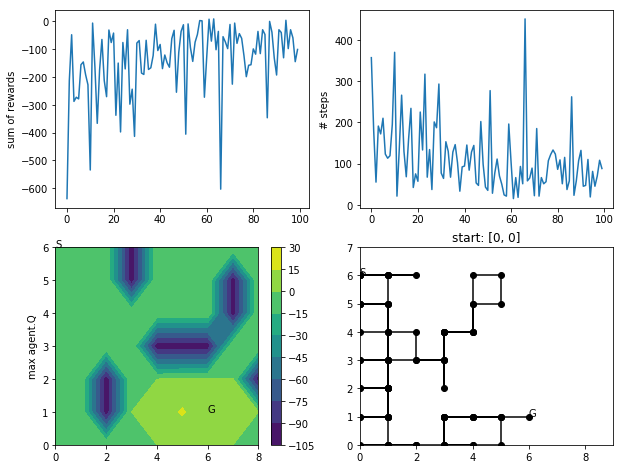

In [186]:
agent=MazeTrain(env, start=[0,0],gamma=0.99, alpha=0.01, epsilon=0.5, maxiter=100, maxstep=1000, method="SARSA", random_start=False)

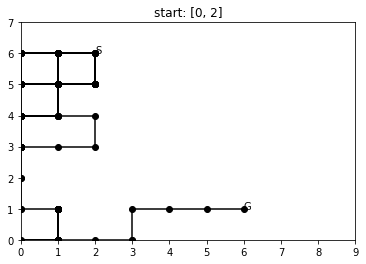

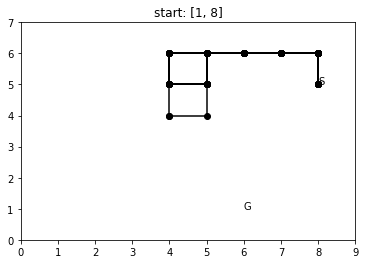

In [187]:
MazeTest(agent, test_start=[[0,2],[1,8]])

Of all the gammas above, it seems that 0.99 is closest to having a increasing trend in the sum of rewards, thus we will choose 0.99

##### gamma: 0.99; alpha: 0.1; epsilon: 0.5

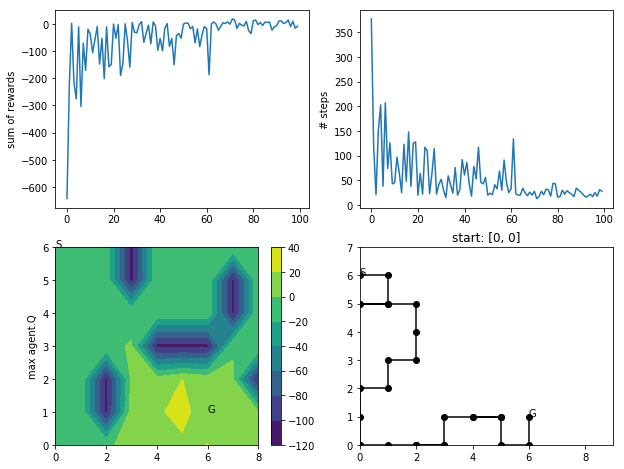

In [192]:
agent=MazeTrain(env, start=[0,0],gamma=0.99, alpha=0.1, epsilon=0.5, maxiter=100, maxstep=1000, method="SARSA", random_start=False)

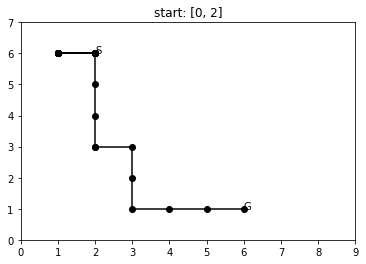

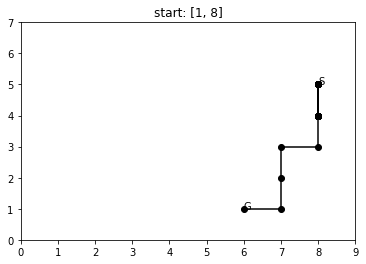

In [193]:
MazeTest(agent, test_start=[[0,2],[1,8]])

Of all the alphas above, 0.1 most deifinetly has a stronger increasing trend in the sum of rewards than 0.01, thus we will choose 0.1

##### gamma: 0.99; alpha: 0.1; epsilon: 0.1

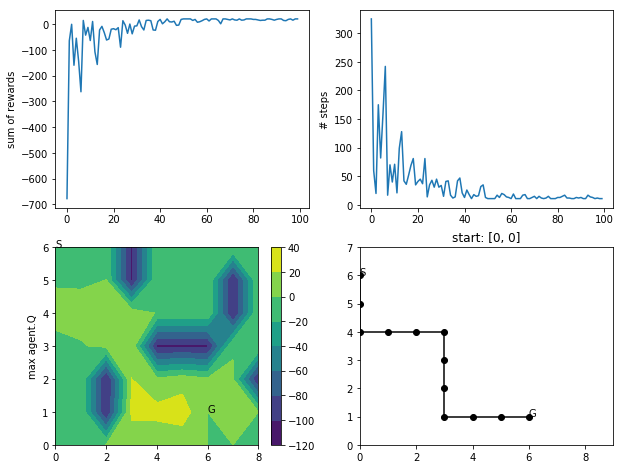

In [194]:
agent=MazeTrain(env, start=[0,0],gamma=0.99, alpha=0.1, epsilon=0.1, maxiter=100, maxstep=1000, method="SARSA", random_start=False)

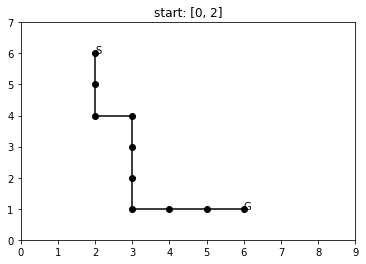

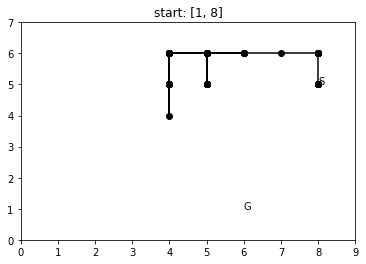

In [195]:
MazeTest(agent, test_start=[[0,2],[1,8]])

Clearly, an epsilon of 0.1 reached convergence compared to epsilon of 0.5, thus we choose 0.1 for the value of epsilon. At this point it has become clear that learning rate of alpha = 0.01 is too small for the number of steps given, thus alpha at 0.1 does a better job. Epsilon of 0.1 means it takes a more exploitation approach rather than exploration, which also explains the faster convergence. gamma values of 0.99 does best because for the RL Agent, future steps are important in determining whether the value of the current action, since it will need many steps before it reaches the goal. Coincidentally, these are the parameters that were provided for testing in the beginning!

Finally, it can be seen that from [1,8], the agent rarely finds the path to G, this is because the training was done with a start at [0,0], thus most of the iterations and steps never crossed the area at [1,8], thus the agent never learned the optimal actions in these areas. However, if we randomly choose the starting point for each round of training, it is possible to learn how to get to the goal from anywhere in the map, albeit with more training iterations.

Without Random Start, 1000 iterations on best parameters chosen

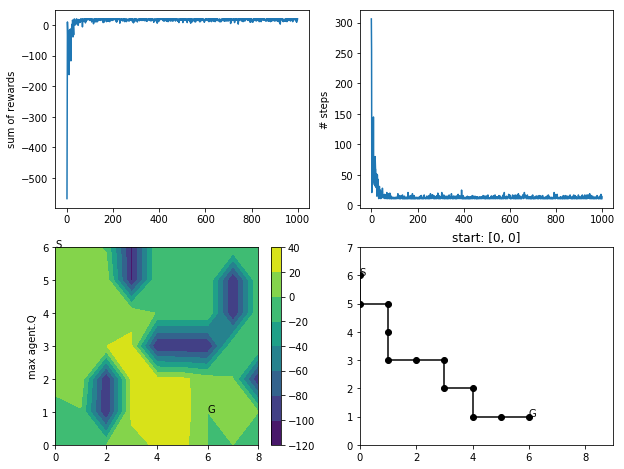

In [252]:
agent=MazeTrain(env, start=[0,0],gamma=0.99, alpha=0.1, epsilon=0.1, maxiter=1000, maxstep=1000, method="SARSA", random_start=False)

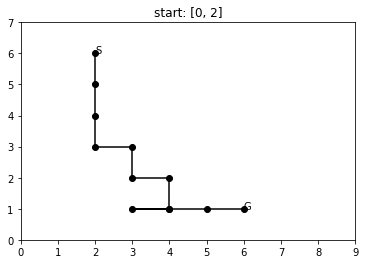

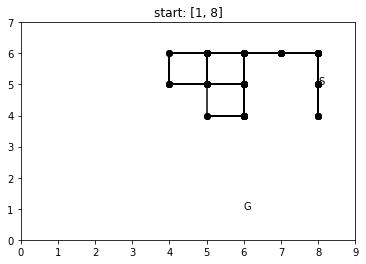

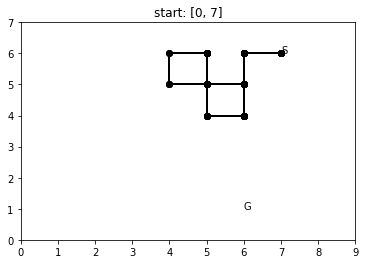

In [253]:
MazeTest(agent, test_start=[[0,2],[1,8],[0,7]])

With random start:

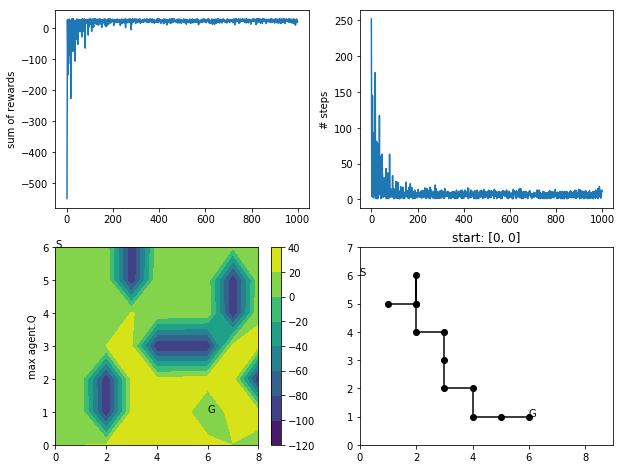

In [205]:
agent=MazeTrain(env, start=[0,0],gamma=0.99, alpha=0.1, epsilon=0.1, maxiter=1000, maxstep=1000, method="SARSA", random_start=True)

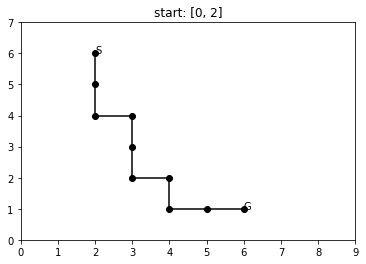

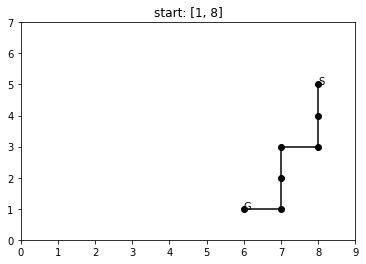

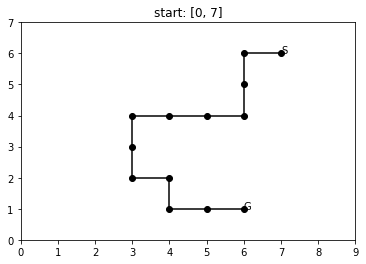

In [206]:
MazeTest(agent, test_start=[[0,2],[1,8],[0,7]])

***Q-learning vs SARSA Training***

parameters:

    gamma: 0.99

    alpha:  0.1

    epsilon:  0.1
    

##### gamma: 0.99; alpha: 0.1; epsilon: 0.1

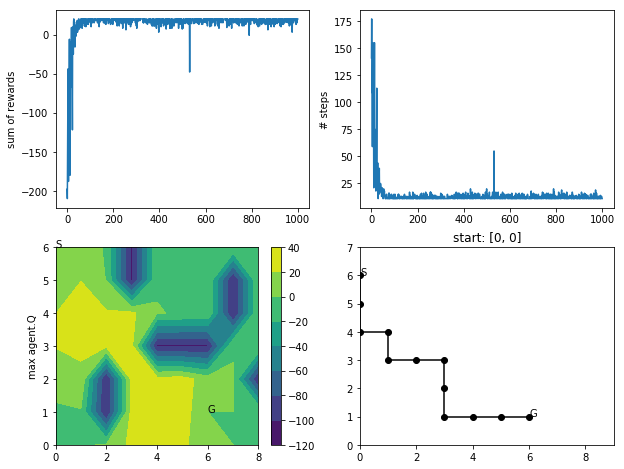

In [244]:
agentQ=MazeTrain(env, start=[0,0],gamma=0.99, alpha=0.1, epsilon=0.1, maxiter=1000, maxstep=1000, method="Q-learning", random_start=False)

Compared With SARSA on the same parameters

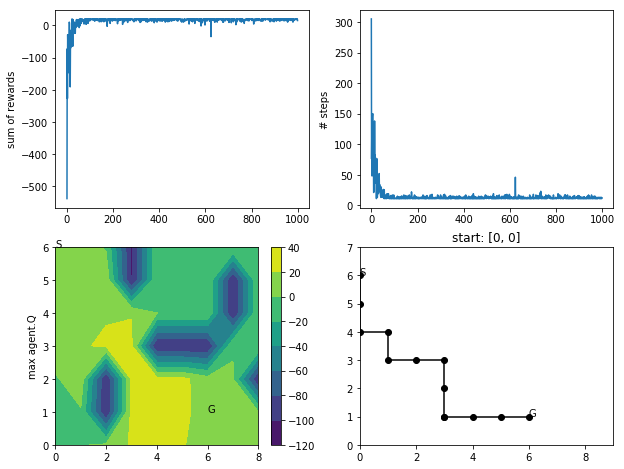

In [245]:
agentS=MazeTrain(env, start=[0,0],gamma=0.99, alpha=0.1, epsilon=0.1, maxiter=1000, maxstep=1000, method="SARSA", random_start=False)

In [213]:
env.print_map()

[['O' 'O' 'O' 'H' 'O' 'O' 'O' 'O' 'O']
 ['O' 'O' 'O' 'H' 'O' 'O' 'O' 'H' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'H' 'O']
 ['O' 'O' 'O' 'O' 'H' 'H' 'H' 'O' 'O']
 ['O' 'O' 'H' 'O' 'O' 'O' 'O' 'O' 'H']
 ['O' 'O' 'H' 'O' 'O' 'O' 'G' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']]


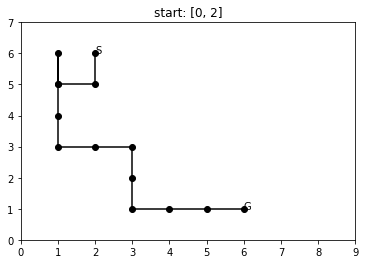

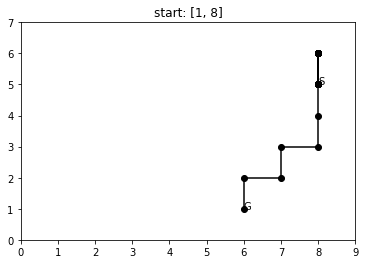

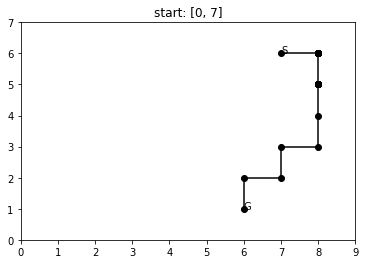

In [246]:
MazeTest(agentQ, test_start=[[0,2],[1,8],[0,7]])

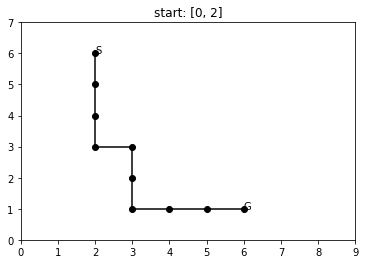

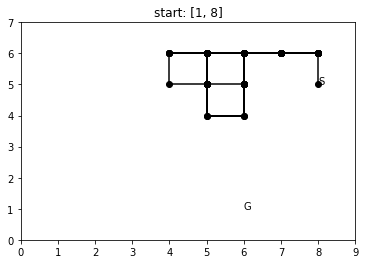

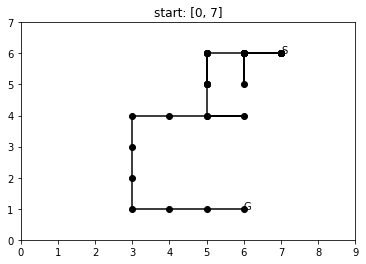

In [247]:
MazeTest(agentS, test_start=[[0,2],[1,8],[0,7]])

Upon comparison, it can be seen that SARSA attempts to be more conservative in starting from [1,8] and [0,7], thus has a harder time finding the route to G. Q-learning, on the other hand takes a more riskier approach since it atttempts to mimick the optimal path, which can be seen as it treads along the right edge to find G.

### Training and Testing with BlackJack
To facilitate the training and reduce number of lines of output, training, plotting will be put into a one line function. Testing will be another function, in which the test's starting point will have to be a list of lists

In [300]:
bj=BlackjackEnv()

In [304]:
#        gamma = params.pop('gamma', 0.99)
#        alpha = params.pop('alpha', 0.1)
#        epsilon= params.pop('epsilon', 0.1)
#        maxiter= params.pop('maxiter', 1000) 
#        method= params.pop('method', "SARSA" )
#        decay_rate=params.pop('decay_rate', 0.9)
#        decay=params.pop('decay', False)
#        custom_reward=params.pop('custom_reward', False)

def BlackJackTrain(env, gamma, alpha, epsilon, maxiter, method, decay, custom_reward):
    agent = BlackJackAgent(env)
    results = agent.train(gamma=gamma, 
                        alpha=alpha, 
                        epsilon=epsilon, 
                        maxiter=maxiter, 
                        method=method,
                        custom_reward=custom_reward,
                        decay=decay)
    plotBlackJackResults(results)
    return agent

def BlackJackTest(agent, niter):
        results = agent.test(niter)
        plotBlackJackResults(results)

***Q-learning Training***
All training was performed with 1000 hands and all tests were performed with 1000 hands
parameters to experiment:

    gamma: 0.1, 0.5, 0.99

    alpha: 0.01, 0.1

    epsilon: 0.5, 0.1
    
Like what I did for the maze problem, I will search through the parameters by finding the best gamma first, then with that gamma finding the best alpha and so on. The initial values for all parameters are the first values listed above

##### gamma: 0.1; alpha: 0.01; epsilon: 0.5

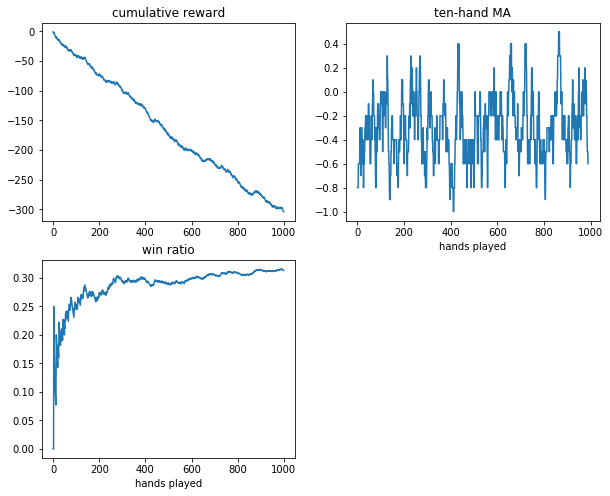

In [344]:
agent=BlackJackTrain(bj, alpha=0.01, gamma=0.1, epsilon=0.5, custom_reward=False, maxiter=1000, decay=False, method="Q-learning")

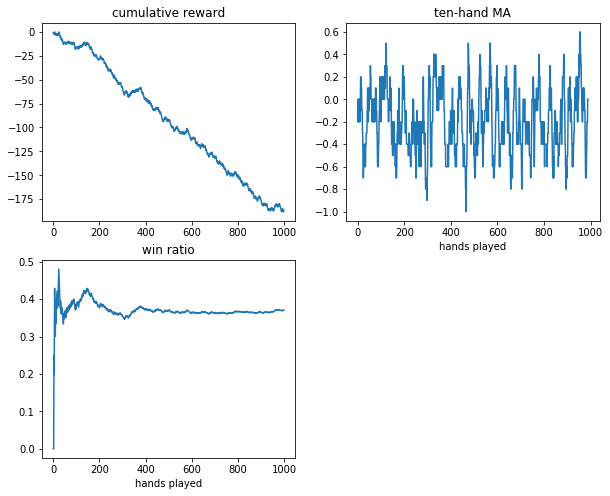

In [345]:
BlackJackTest(agent=agent, niter=1000)

##### gamma: 0.5; alpha: 0.01; epsilon: 0.5

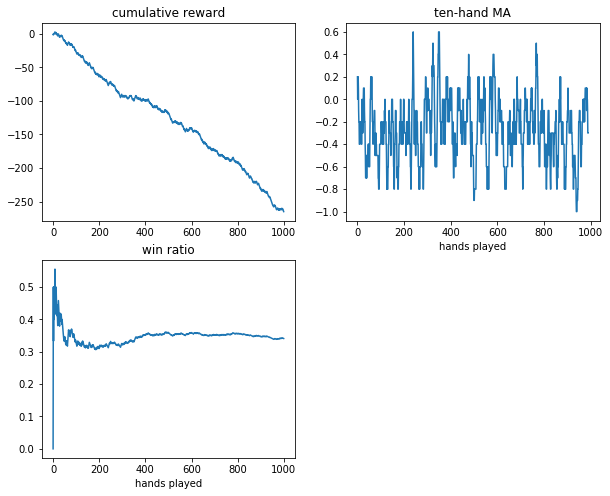

In [356]:
agent=BlackJackTrain(bj, alpha=0.01, gamma=0.5, epsilon=0.5, custom_reward=False, maxiter=1000, decay=False, method="Q-learning")

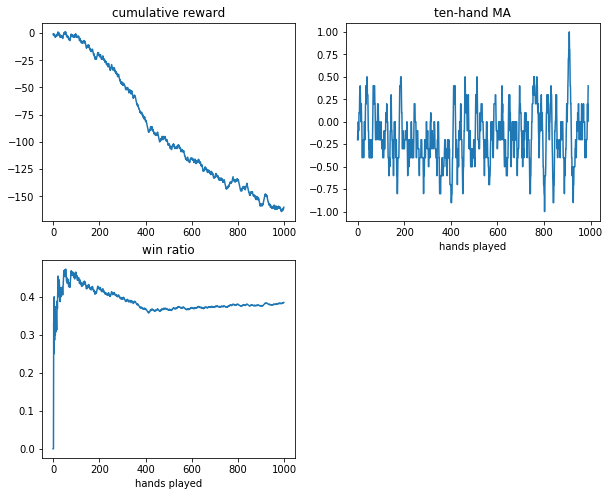

In [357]:
BlackJackTest(agent=agent, niter=1000)

##### gamma: 0.99; alpha: 0.01; epsilon: 0.5

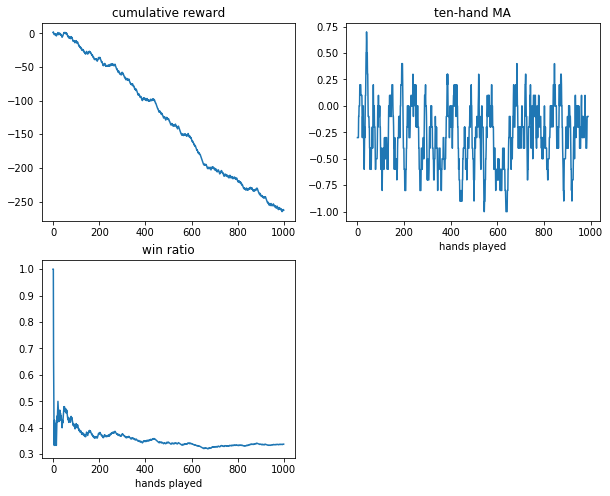

In [358]:
agent=BlackJackTrain(bj, alpha=0.01, gamma=0.99, epsilon=0.5, custom_reward=False, maxiter=1000, decay=False, method="Q-learning")

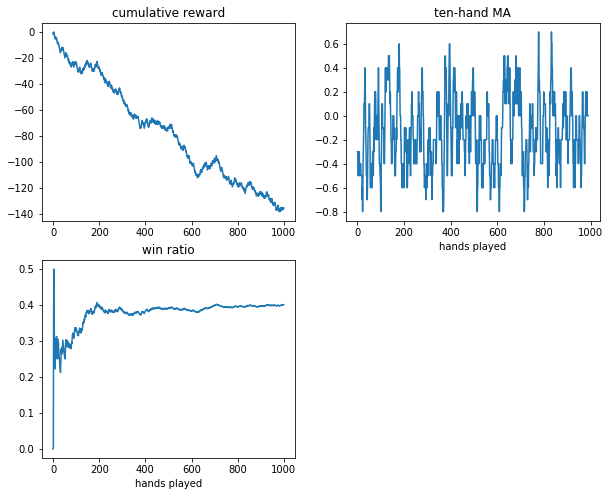

In [359]:
BlackJackTest(agent=agent, niter=1000)

Thus gamma is chose to be 0.99 based on the win ratio and cumulative reward at the end

##### gamma: 0.99; alpha: 0.1; epsilon: 0.5

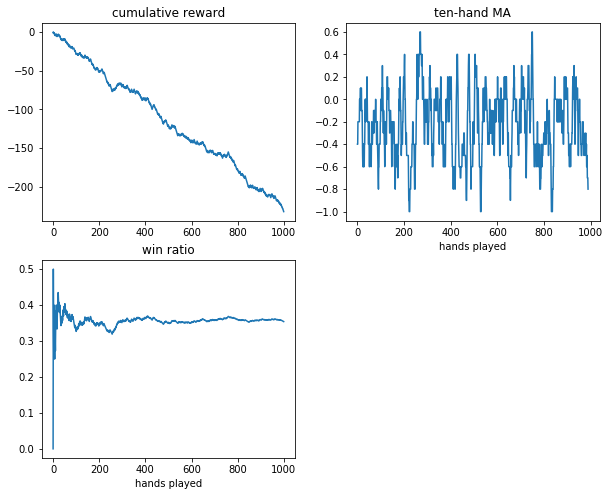

In [360]:
agent=BlackJackTrain(bj, alpha=0.1, gamma=0.99, epsilon=0.5, custom_reward=False, maxiter=1000, decay=False, method="Q-learning")

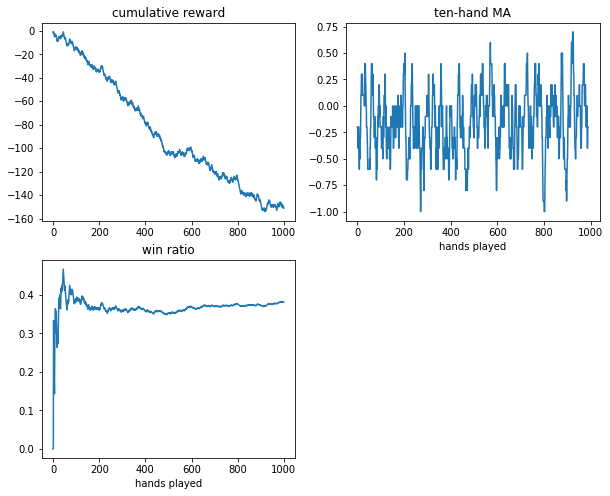

In [361]:
BlackJackTest(agent=agent, niter=1000)

Thus alpha is chosen to be 0.01

##### gamma: 0.99; alpha: 0.01; epsilon: 0.1

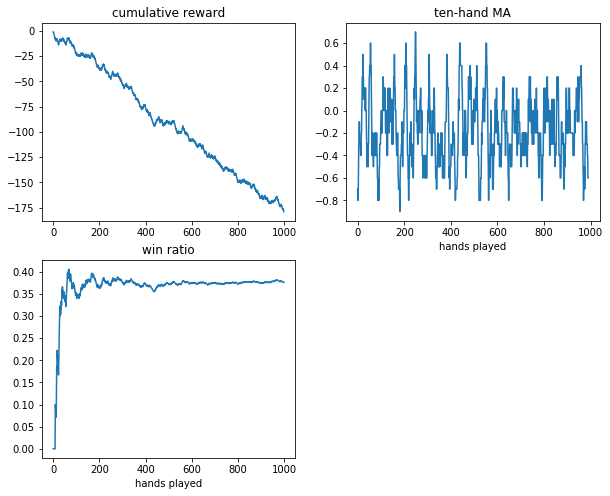

In [362]:
agent=BlackJackTrain(bj, alpha=0.1, gamma=0.99, epsilon=0.1, custom_reward=False, maxiter=1000, decay=False, method="Q-learning")

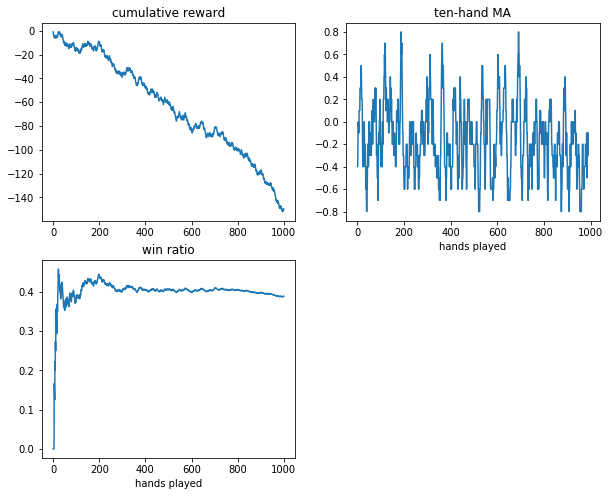

In [363]:
BlackJackTest(agent=agent, niter=1000)

Finally, we have all three parameters chosen based on the testing results: 
- gamma = 0.99
- alpha = 0.1
- epsilon = 0.1

Furthermore, using the chosen parameters, I would like to see if a custom reward function will have different results

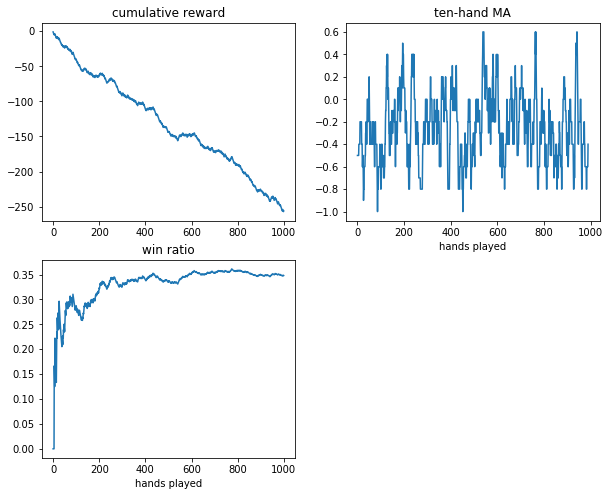

In [364]:
agent=BlackJackTrain(bj, alpha=0.1, gamma=0.99, epsilon=0.1, custom_reward=True, maxiter=1000, decay=False, method="Q-learning")

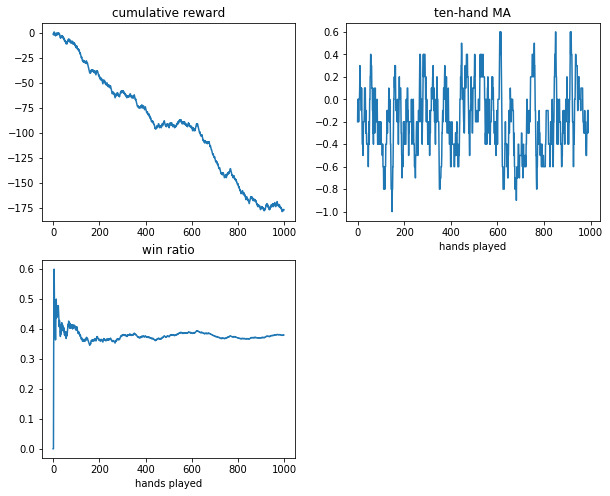

In [365]:
BlackJackTest(agent=agent, niter=1000)

It turns out that learning with a custom rewards function on the chosen parameters led to a slightly worse result

What about adding epsilon decay to the current best agent??

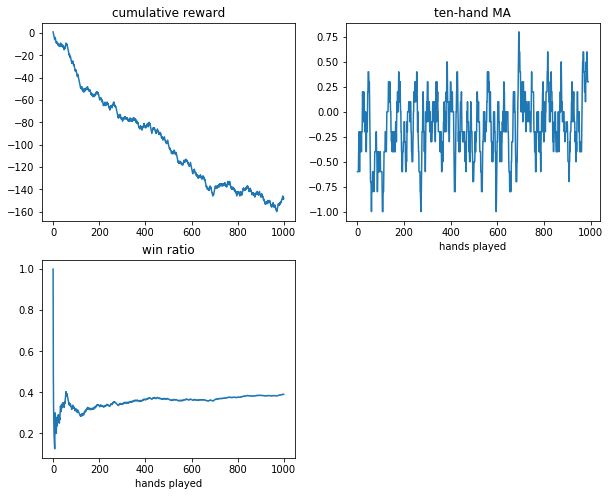

In [370]:
agent=BlackJackTrain(bj, alpha=0.01, gamma=0.99, epsilon=0.1, custom_reward=False, maxiter=1000, decay=True, method="Q-learning")

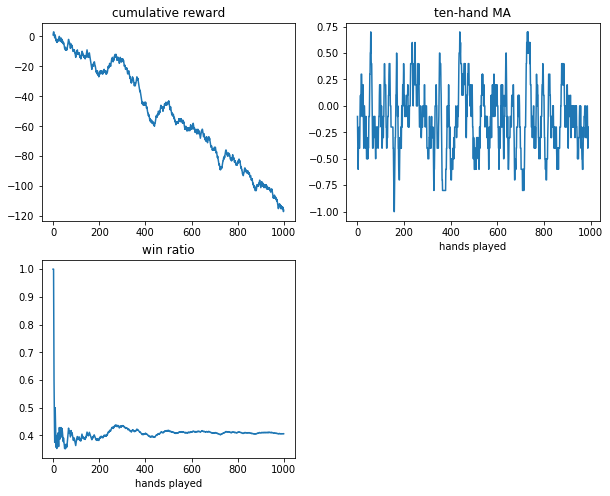

In [371]:
BlackJackTest(agent=agent, niter=1000)

It turns out that adding a certain amount of decay to epsilon returns much better results.

In this experiment, it can be seen that the gamma value doesn't matter as much as it did for the Maze problem, this might be because in the blackjack there aren't too many steps a player can take before a new hand begins, thus future steps don't matter uite as much. Furthermore, epsilon decay or a smaller epsilon helped increase the chances of a player winning simply because a learned policy is better than randomly exploration in the game of blackjack, in which the player is at a huge disadvantage. The ten hand Moving Average shown exhibits the nature of blackjack, in which we can see the amount of stochasticity with each hand. This kind of randomness is hard to learn from, and under different iterations of training one might generate very different policies.

# V. Conclusions

Discuss the challenges or somethat that you learned. 
If you have any suggestion about the assignment, you can write about it. 
From this challenge, I learned more about the difference between Q-learning and SARSA, which is that Q-learning tries to learn from the optimal strategy no matter the consequence while SARSA adjusts it current policy to the risks it sees. This a fundamental difference and factor that needs to be considered when choosing a TD learning scheme for practical problems.

# Extra Credit

- Let us have Blackjack-V0 Tournament in class (Mar 22nd.)!
- Top 4 students will get an extra credit. 
- 2 (or more?) unique training attemps will also get an extra credit. (Sales for it to be considered.) 

## Grading

We will test your notebook with an additional grid.txt file. Please make sure to test in different maze input files. 

points | | description
--|--|:--
5 | Overview| states the objective and the appraoch 
10 | Maze Problem | 
 | 5| Includes description of maze problem
 | 5| Explains the GridWorld
10 | Blackjack
 | 5| Includes description of blackjack problem
 | 5| Explains the Backjack-V0 (OpenAI Gym)
25 | Methods | 
 | 5| Review of the SARSA and Q-Learning
 | 5| Choice of TD learning and Reason
 |10| Implementation of the selected approach
 | 5| explanation of the codes
45 | Results 
| 5| Reports the selected parameters for both problems. 
|20| Experimental outputs that show the choice of parameters. How do you choose them? (10 points per each problem)
|10| Output plots (5 for each)
|10| reading and analysis of learning results and plots (5 for each)
5 | Conclusions 
